In [172]:
using Random, Distributions
using Plots
# plotlyjs()
# using PlotlyJS
using DataFrames
using StatsBase
using DelimitedFiles
using LinearAlgebra
# using Distances
# using Symbolics
# using Latexify

# Problem Set 5 (Jonathan Fischer using Julia)

## 1) Langevin Dynamics of minimalist HP 

### Initialize Positions R

In [173]:
function initR()
    R = zeros((5,3))
    R[:,3] .= 1,2,3,4,5
    R
end

initR (generic function with 1 method)

### Calculate distance (single component)

In [24]:
function calc_dist(x1,x2) #calculate distance between a single pair of points along single component
    x1-x2 
    # dx - L*round(dx/L) #distance using minimum image convention 
end

calc_dist (generic function with 1 method)

### Calculate non-bonded potential 

In [25]:
function calc_LJ(r, epsilon, sigma = 1) # calculate Lennard_Jones potential for a pairwise distance
    4*epsilon*((sigma/r)^12 - (sigma/r)^6) 
end

calc_LJ (generic function with 2 methods)

### Calculate force (dU + friction + noise) returns tuple of force terms

In [83]:
function calc_LJforce(r, epsilon, T, v, dt, sigma = 1, k=1, m=1, eta=0.05)
    # (48*epsilon*((sigma^12/r^13)-0.5*(sigma^6/r^7)) + randn()*√(2kT*m*eta/dt) - eta*m*v, 
    48*epsilon*((sigma^12/r^13)-0.5*(sigma^6/r^7))
end

calc_LJforce (generic function with 5 methods)

### Calculate random force 

In [68]:
function calc_randomforce(T,dt,k=1,m=1,eta=0.05)
    randn(5,3)*√(2k*T*m*eta/dt)
end

calc_randomforce (generic function with 4 methods)

### Calculate dissapative force

In [69]:
function calc_dissforce(v,m=1,eta=0.05)
    -(eta*m*v)
end

calc_dissforce (generic function with 3 methods)

### Calculate bonded potential

In [70]:
function calc_harmU(r,k=20,l=1)
    0.5k*(r-l)^2
end

calc_harmU (generic function with 3 methods)

### Calculate bond force

In [112]:
function calc_harmforce(r,k=20,l=1)
    -k*(r-l)
end

calc_harmforce (generic function with 3 methods)

### Update acceleration matrix A

In [113]:
function update_A(R, T, V, dt, m = 1) #update distance matrix D and acceleration matrix A 
    PE = 0 #initialize potential energy
    N = 5
    Ac = zeros(N,3)
    Ar = calc_randomforce(T,dt)
    Az = calc_dissforce.(V)

    for i in 1:N-1
        for j in i+1:N
            dr = calc_dist.(R[i,:],R[j,:]) #calculate distance vector between two points
            r_mag = norm(dr) #calculate magnitude of distance vector
            if j - i > 1
                if (i,j) == (1,4) || (i,j) == (1,5) || (i,j) == (4,5)
                    epsilon = 1.
                    PE += calc_LJ(r_mag, epsilon)  #accumulate LJ potential energy

                    Ac[i,:] += calc_LJforce(r_mag,epsilon,T,norm(V[i,:]),dt) * dr / r_mag
                    Ac[j,:] -= calc_LJforce(r_mag,epsilon,T,norm(V[j,:]),dt) * dr / r_mag
                else
                    epsilon = 2/3
                    PE += calc_LJ(r_mag, epsilon)  #accumulate LJ potential energy

                    Ac[i,:] += calc_LJforce(r_mag,epsilon,T,norm(V[i,:]),dt) * dr / r_mag
                    Ac[j,:] -= calc_LJforce(r_mag,epsilon,T,norm(V[j,:]),dt) * dr / r_mag
                end
            else 
                PE += calc_harmU(r_mag)
                # fvector = [x * dr/ r_mag for x in calc_harmforce(r_mag)]
                # return fvector
                fvector = calc_harmforce(r_mag) * dr / r_mag
                Ac[i,:] += fvector
                Ac[j,:] -= fvector
            end
        end
    end
    return PE, Ac, Ar, Az
end

update_A (generic function with 2 methods)

### Calculate new position {vector}

In [30]:
function calc_position(r, v, a, dt) #update position vector for single particle
    r + (v*dt) + 0.5(a*dt^2)
end

calc_position (generic function with 1 method)

### Update position matrix R in place (V,A,dt)

In [31]:
function update_R!(R, V, A, dt) #updates position matrix R IN PLACE
    broadcast!(calc_position,R,R,V,A,dt) #vectorized operation passed R by reference 
end

update_R! (generic function with 1 method)

### Calculate velocity {v::float, a1::float, a2::float, dt::float} with BBK

In [32]:
function calc_velocity(v,a1,a2c,a2r,dt,eta=0.05) #velocity verlet update of velocity for single component
    (1+dt*eta/2)^-2 * (v + 0.5(a1)*dt + 0.5(a2c + a2r)*dt) #average current and new accelerations
end

calc_velocity (generic function with 3 methods)

### Update velocity matrix V (V,A1,A2,dt)

In [111]:
function update_V!(V,A1,A2c,A2r,dt) #updates velocity matrix V IN PLACE (passed by reference)
    # A2c = copy(A2[:,:,1])
    # A2r = copy(A2[:,:,2])
    broadcast!(calc_velocity,V,V,A1,A2c,A2r,dt)
end

update_V! (generic function with 2 methods)

### Initialize velocity (T,N,m,k)

In [35]:
function init_velocity(T, N, m=1, k=1) #temperature, count, and mass
    V = √(k*T/m)*randn((N,3)) #return N x 3 matrix of initialized velocities sampled from Maxwell-Boltzmann distribution
    V[end,:] = -sum(V[1:end-1,:],dims=1) #Momentum conservation: last row equals minus sum of all other rows. Mass cancels out because same species 
    return V
end

init_velocity (generic function with 3 methods)

### Calculate KE and T

In [36]:
function calc_KE(V, N, m =1)
    KE = 0.
    T = 0.
    for p in eachrow(V)
        v_squared = sum(p.^2) #get squared magnitude of velocity vector
        KE += 0.5(m*v_squared) #accumulate KE for each particle
        T += v_squared/(3N-3)
    end
    return KE, T 
end

calc_KE (generic function with 2 methods)

### LD Simulation

In [114]:
function LD(T, dt, iters)

    R = initR()
    N = length(R[:,1]) #number of particles
    V = init_velocity(T,N) #velocity for t
    # A = zeros(N,3,3) #acceleration matrix
    
    PE = Vector{Float64}(undef,iters+1) #initialize array of potential energies 
    # return fvector = update_A(R,T,V,dt) #initialize acceleration matrix and return initial PE

    PE[1], Ac, Ar, Az = update_A(R,T,V,dt) #initialize acceleration matrix and return initial PE
    
    

    KE = Vector{Float64}(undef,iters+1) #initialize array of kinetic energies 
    KE[1], = calc_KE(V,N) #initial KE 

    T_list = Vector{Float64}(undef,iters+1) #initialize array of kinetic energies 
    T_list[1] = T #initial temperature


    for i in 1:iters
        # curr_A = dropdims(sum(copy(A),dims=3),dims=3) #A for current t
        curr_A = Ac + Ar + Az
        update_R!(R,V,curr_A,dt) #new R updated to t+dt
        PE[i+1],Ac, Ar, Az = update_A(R,T,V,dt) #new A updated in-place to t+dt, and returns PE into array 
        # Ac = copy(A[:,:,1])
        # Ar = copy(A[:,:,2])
        update_V!(V,curr_A,Ac,Ar,dt) #new V updated to t+dt
        KE[i+1],T_list[i+1] = calc_KE(V,N) #add KE
        # T_list[i+1] = calc_T(KE[i+1],kb,N) #add T
    end
    return  PE, KE, T_list, Ac, Ar, Az, V, R 
end

LD (generic function with 2 methods)

In [115]:
# Random.seed!(1234)
PE, KE, T_list, Ac, Ar, Az, V, R= LD(2.,0.003,10000)

([-0.13315560198848553, -0.12946887819617442, -0.118968556349855, -0.10144110797806617, -0.0767827190444407, -0.045079536300469195, -0.006263673793675956, 0.03976049090505705, 0.09254153658185973, 0.15147573457254873  …  2.5098072049672564, 2.5837157241355744, 2.6584673070519167, 2.732746348758287, 2.8041396365832507, 2.875367263587399, 2.9465643016840986, 3.017266704292286, 3.0883338017311934, 3.1577620505048967], [24.344601506121684, 24.423705578011344, 24.527141345569227, 24.465463566729753, 24.44910249075608, 24.494747944983565, 24.55204355531731, 24.488305089921777, 24.404655898184746, 24.280467642518374  …  12.330285789772283, 12.374458678452974, 12.451341873549008, 12.479264679697634, 12.42435159228736, 12.357651630247878, 12.396234575535948, 12.390222028606946, 12.31518264664184, 12.311852503399633], [2.0, 4.070617596335224, 4.0878568909282045, 4.077577261121625, 4.074850415126013, 4.082457990830594, 4.092007259219552, 4.081384181653629, 4.067442649697458, 4.046744607086396  … 

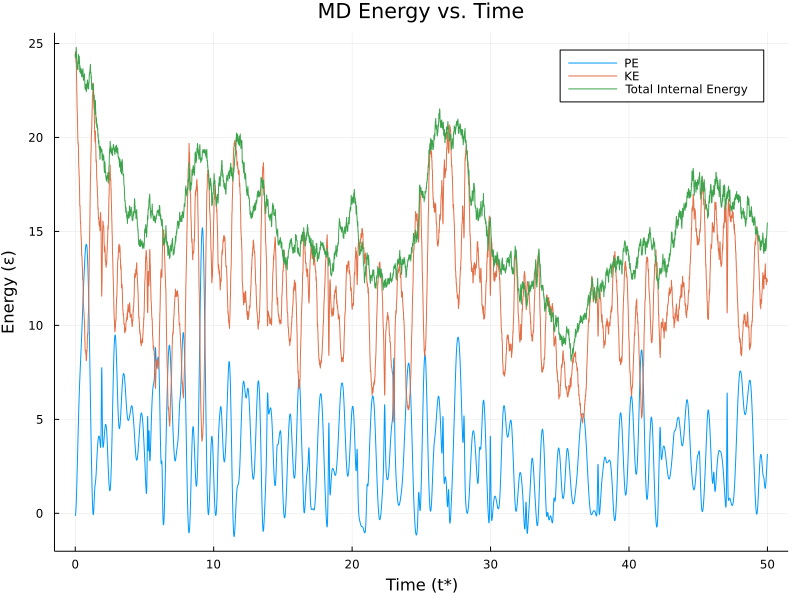

In [117]:
p1 = plot(range(0,length = 10001, step=0.005),PE, label = "PE", size = (800,600))
plot!(range(0,length = 10001, step=0.005),KE, label = "KE")
plot!(range(0,length = 10001, step=0.005),PE+KE, label = "Total Internal Energy")
title!("MD Energy vs. Time")
xlabel!("Time (t*)")
ylabel!("Energy (ε)")
savefig("plot1a.png")
display(p1)

### g) Average PE and KE over last 1000 steps

In [129]:
println("Average PE: $(mean(PE[end-1000:end])) ε")

Average PE: 3.110280564657421 ε


In [130]:
println("Average KE: $(mean(KE[end-1000:end])) ε")

Average KE: 13.193026540714715 ε


## 5) Reaction Diffusion

In [255]:
function gillespie_alg(model, u0, tend, p, stoich; tstart=zero(tend))
    t = tstart   # Current time
    ts = [t]     # Time points
    u = copy(u0) # Current state
    us = copy(u) # Record of states
    counter = 0
    while t < tend
        a = model(u, p)               # propensities
        dt = randexp() / sum(a)          # Time step
        du = sample(stoich, Weights(a))  # Choose the stoichiometry for the next reaction
        
        u .+= du  # Update state
        t += dt   # Update time
        counter += 1
        
        if mod(counter,7) == 0
            us = [us u]  # Append state variable to record
            push!(ts, t) # Append time point to record
        end
    end
    # Make column as variables, rows as observations
    # us = collect(us')
    return (t = ts, u = us)
end

gillespie_alg (generic function with 1 method)

In [211]:
y0 = [[180,360],[180,360]]
h = 2 #mi lengthscale
Dprey = 0.2 
Dpred = 0.02

0.02

In [285]:
"Propensity model using copy numbers"
model(y, c) = [c.k1 * y[1][1],  c.k2 * y[1][1] * y[1][2], c.k4 * y[1][2],c.preyDiff * y[1][1],c.predDiff * y[1][2],       c.k1 * y[2][1],  c.k2 * y[2][1] * y[2][2], c.k4 * y[2][2],c.preyDiff * y[2][1],c.predDiff * y[2][2]]

parameters = (k1=10.0, k2=0.03, k4 = 9.0, preyDiff = Dprey/h^2, predDiff = Dpred/h^2, stoich=[[[1, 0],[0,0]], [[-1, 1],[0,0]], [[0,-1],[0,0]],[[-1,0],[1,0]],[[0,-1],[0,1]],     [[0,0],[1, 0]], [[0,0],[-1, 1]], [[0,0],[0,-1]],[[1,0],[-1,0]],[[0,1],[0,-1]]])
# y0 = [180, 360]
tend = 10.0

10.0

In [286]:
gil_sol = gillespie_alg(model, y0, tend, parameters, parameters.stoich)

(t = [0.0, 0.0006841982411161093, 0.0010516557055885085, 0.0015424447474650521, 0.002084765339971748, 0.0025414307371521604, 0.003400977954114079, 0.0038350997268884694, 0.004422302138411591, 0.005157158267565199  …  9.997616903998537, 9.997978596635061, 9.998492189801356, 9.99867487342925, 9.998931904587716, 9.99910635192382, 9.999253801182448, 9.999446279929629, 9.999652610455323, 9.999845745767717], u = [[180, 360] [182, 357] … [216, 569] [217, 566]; [180, 360] [179, 360] … [91, 1278] [91, 1275]])

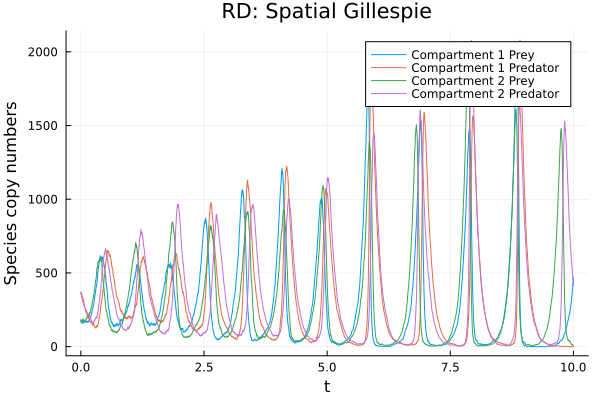

In [279]:
plot(gil_sol.t,[x[1] for x in gil_sol.u[1,:]])
gil_plot = plot(gil_sol.t,[x[1] for x in gil_sol.u[1,:]], label = "Compartment 1 Prey")
plot!(gil_sol.t,[x[2] for x in gil_sol.u[1,:]], label = "Compartment 1 Predator")
plot!(gil_sol.t,[x[1] for x in gil_sol.u[2,:]], label = "Compartment 2 Prey")
plot!(gil_sol.t,[x[2] for x in gil_sol.u[2,:]], label = "Compartment 2 Predator")
xlabel!("t")
ylabel!("Species copy numbers")
title!("RD: Spatial Gillespie")
savefig("prob5_b.png")
display(gil_plot)

### c) Fast Diffusion

In [288]:
"Propensity model using copy numbers"
model(y, c) = [c.k1 * y[1][1],  c.k2 * y[1][1] * y[1][2], c.k4 * y[1][2],c.preyDiff * y[1][1],c.predDiff * y[1][2],       c.k1 * y[2][1],  c.k2 * y[2][1] * y[2][2], c.k4 * y[2][2],c.preyDiff * y[2][1],c.predDiff * y[2][2]]

parameters = (k1=10.0, k2=0.03, k4 = 9.0, preyDiff = Dprey*20/h^2, predDiff = Dpred*20/h^2, stoich=[[[1, 0],[0,0]], [[-1, 1],[0,0]], [[0,-1],[0,0]],[[-1,0],[1,0]],[[0,-1],[0,1]],     [[0,0],[1, 0]], [[0,0],[-1, 1]], [[0,0],[0,-1]],[[1,0],[-1,0]],[[0,1],[0,-1]]])
# y0 = [180, 360]
tend = 10.0

10.0

In [289]:
gil_sol2 = gillespie_alg(model, y0, tend, parameters, parameters.stoich)

(t = [0.0, 0.0003923244509094772, 0.001132596710127844, 0.0014456694640302733, 0.002089296661552176, 0.0027813761737685316, 0.0031075085371231894, 0.003804866819387852, 0.004144161562520751, 0.004607233957499923  …  9.996575447488597, 9.99687654343282, 9.997272978268883, 9.99772414795655, 9.997875952863403, 9.998250918603922, 9.998603326276937, 9.99925181164064, 9.999420156821257, 9.999705306650146], u = [[180, 360] [180, 358] … [321, 288] [323, 285]; [180, 360] [181, 359] … [441, 180] [443, 180]])

In [290]:
gil_sol2.u

2×26404 Matrix{Vector{Int64}}:
 [180, 360]  [180, 358]  [181, 356]  …  [319, 289]  [321, 288]  [323, 285]
 [180, 360]  [181, 359]  [183, 357]     [441, 178]  [441, 180]  [443, 180]

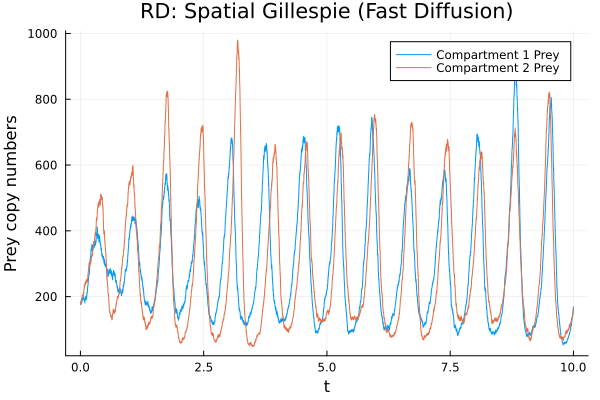

In [284]:
plot(gil_sol.t,[x[1] for x in gil_sol.u[1,:]])
gil_plot = plot(gil_sol.t,[x[1] for x in gil_sol.u[1,:]], label = "Compartment 1 Prey")
# plot!(gil_sol.t,[x[2] for x in gil_sol.u[1,:]], label = "Compartment 1 Predator")
plot!(gil_sol.t,[x[1] for x in gil_sol.u[2,:]], label = "Compartment 2 Prey")
# plot!(gil_sol.t,[x[2] for x in gil_sol.u[2,:]], label = "Compartment 2 Predator")
xlabel!("t")
ylabel!("Prey copy numbers")
title!("RD: Spatial Gillespie (Fast Diffusion)")
savefig("prob5_c.png")
display(gil_plot)

In [291]:
"There is far less accumulation of any one species, because the faster diffusion rate equilibrates the two compartments much faster"

"There is far less accumulation of any one species, because the faster diffusion rate equilibrates the two compartments much faster"